# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/offline_mechanism/')

In [3]:
from load_ensembles import *

In [4]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [5]:
from utils import *

In [6]:
from load_gridcell_areas import *

# Load data

### Land variables:
* MML_fsns        (time, lat, lon) float32 ...
* time_bounds     (time, hist_interval) object ...
* MML_flns        (time, lat, lon) float32 ...
* MML_l2a_tref2m  (time, lat, lon) float32 ...
* MML_lhflx       (time, lat, lon) float32 ...
* MML_shflx       (time, lat, lon) float32 ...
* MML_lwdn        (time, lat, lon) float32 ...
* MML_ts          (time, lat, lon) float32 ...
    
### ATM variables
* TREFHT     (time, lat, lon) float32 ...
* time_bnds  (time, nbnd) object ...
* TS         (time, lat, lon) float32 ...
* FLNS       (time, lat, lon) float32 ...
* FSNS       (time, lat, lon) float32 ...
* LHFLX      (time, lat, lon) float32 ...
* SHFLX      (time, lat, lon) float32 ...
* SWCF       (time, lat, lon) float32 ...
* LWCF       (time, lat, lon) float32 ...
* ICEFRAC    (time, lat, lon) float32 ...
* CLDLOW     (time, lat, lon) float32 ...
* CLDMED     (time, lat, lon) float32 ...
* FSNT       (time, lat, lon) float32 ...
* FLNT       (time, lat, lon) float32 ...

### Get coupled data

In [16]:
def get_data(runname,
            fpath='/glade/work/czarakas/Lague_kernels/Coupled/',
            suffix='.clm2.h0.20-50.time_mean.lnd_vars.nc'):
    ds=xr.open_dataset(fpath+runname+suffix)
    return ds

In [17]:
Albedo1=get_data('global_a1_cv2_hc0.1_rs100_cheyenne')
Albedo3=get_data('global_a3_cv2_hc0.1_rs100_cheyenne')

HC_pt01=get_data('global_a2_cv2_hc0.01_rs100_cheyenne')
HC_pt05=get_data('global_a2_cv2_hc0.05_rs100_cheyenne')
HC_pt1=get_data('global_a2_cv2_hc0.1_rs100_cheyenne')
HC_pt5=get_data('global_a2_cv2_hc0.5_rs100_cheyenne')
HC1=get_data('global_a2_cv2_hc1.0_rs100_cheyenne')
HC2=get_data('global_a2_cv2_hc2.0_rs100_cheyenne')
HC5=get_data('global_a2_cv2_hc5.0_rs100_cheyenne')
HC10=get_data('global_a2_cv2_hc10.0_rs100_cheyenne')
HC20=get_data('global_a2_cv2_hc20.0_rs100_cheyenne')

REF=get_data('global_a2_cv2_hc0.1_rs100_cheyenne')

RS200 = get_data('global_a2_cv2_hc0.1_rs200_cheyenne')
RS30 = get_data('global_a2_cv2_hc0.1_rs30_cheyenne')


# Calculate vegetation height kernels

In [17]:
heights=np.array([0.01, 0.05, 0.1, #0.5,
                  1, 2, 5, 10, 20])
datasets=[HC_pt01.MML_ts,
          HC_pt05.MML_ts,
          HC_pt1.MML_ts,
          #HC_pt5.MML_ts.mean(dim='record'),
          HC1.MML_ts,
          HC2.MML_ts,
          HC5.MML_ts,
          HC10.MML_ts,
          HC20.MML_ts
         ]

delta_heights=(heights[1:]-heights[:-1])

In [19]:
delta_init=datasets[1].mean(dim='time')-datasets[0].mean(dim='time')
da=delta_init.expand_dims({'start_height':heights[:-1]}).copy()
ds=da.to_dataset(name='TS_change')

In [20]:
for i, hc in enumerate(heights[:-1]):
    print(i)
    ds.TS_change[i,:,:]=(datasets[i+1].mean(dim='time')-datasets[i].mean(dim='time'))

0
1
2
3
4
5
6


In [21]:
TS_change_per_m=np.zeros(np.shape(ds.TS_change.values))
TS_change_per_m[:]=np.nan
for i, hc in enumerate(ds.start_height):
    TS_change_per_m[i,:,:]=ds.TS_change.values[i,:,:]/delta_heights[i]

In [22]:
ds['TS_change_per_m']=xr.DataArray(
    data=TS_change_per_m,
    dims=ds['TS_change'].dims,
    coords=dict(
        start_height=(["start_height"], ds.start_height),
        lat=(["lat"], ds.lat),
        lon=(["lon"], ds.lon)))

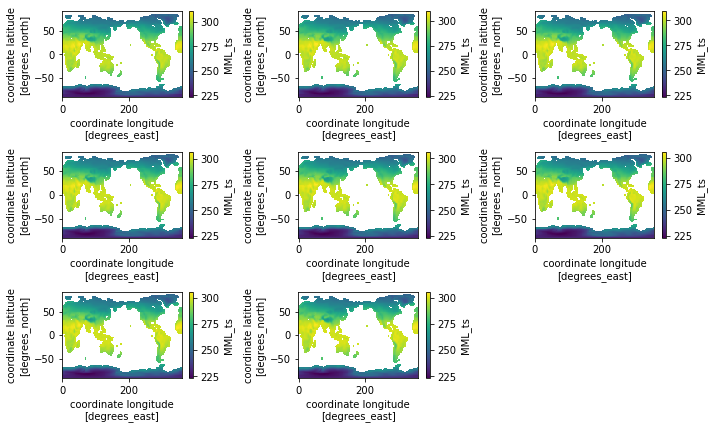

In [23]:
plt.figure(figsize=(10,6))
for i in np.arange(0,np.size(ds.start_height)+1):
    plt.subplot(3,3,i+1)
    datasets[i].mean(dim='time').plot()
plt.tight_layout()

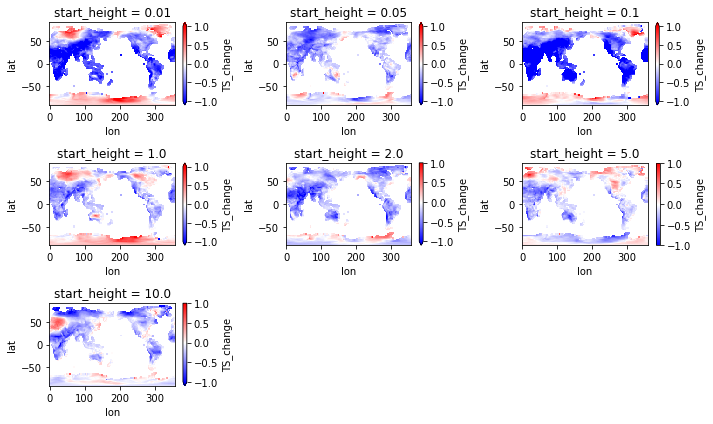

In [24]:
plt.figure(figsize=(10,6))
for i in np.arange(0,np.size(ds.start_height)):
    plt.subplot(3,3,i+1)
    ds.TS_change[i,:,:].plot(cmap=plt.cm.bwr,vmin=-1, vmax=1)
plt.tight_layout()

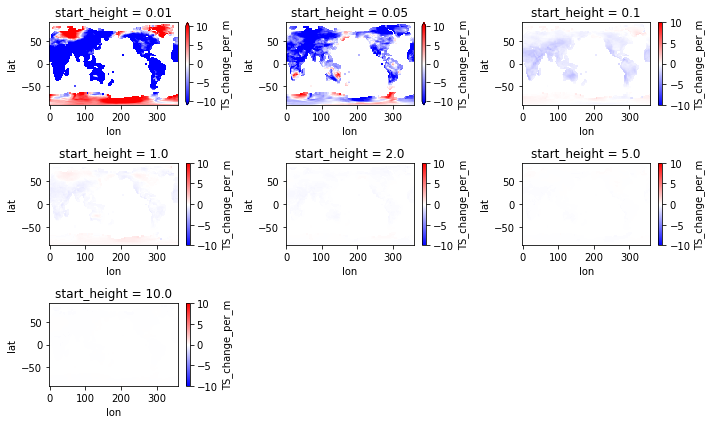

In [25]:
plt.figure(figsize=(10,6))
for i in np.arange(0,np.size(ds.start_height)):
    plt.subplot(3,3,i+1)
    ds.TS_change_per_m[i,:,:].plot(cmap=plt.cm.bwr,vmin=-10, vmax=10)
plt.tight_layout()

In [26]:
fpath_out='/glade/work/czarakas/coupled_PPE/data/Lague_kernels/'
ds.to_netcdf(fpath_out+'coupled_deltaTs_deltaHc_allHeights.nc')

In [61]:
fpath_out='/glade/work/czarakas/coupled_PPE/data/Lague_kernels/'

In [58]:
delta_ts_hc=(HC_pt01.MML_ts.mean(dim='time')-HC_pt05.MML_ts.mean(dim='time'))
delta_hc=(20-10)
suffix='init_20'
deltaTs_deltaHc=delta_ts_hc/delta_hc
ds_deltaTs_deltaHc=deltaTs_deltaHc.to_dataset('deltaTs_deltaHc')
ds_deltaTs_deltaHc.to_netcdf(fpath_out+'coupled_deltaTs_deltaHc_'+suffix+'.nc')

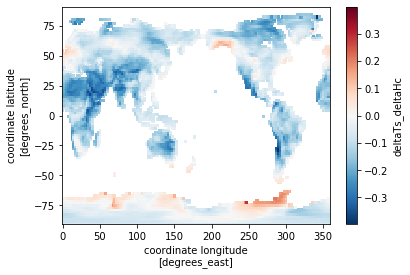

In [56]:
ds_deltaTs_deltaHc.deltaTs_deltaHc.plot()#vmin=-30, vmax=30,cmap=plt.cm.bwr)

In [59]:
ds_deltaTs_deltaHc

<xarray.Dataset>
Dimensions:          (lat: 96, lon: 144)
Coordinates:
  * lat              (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * lon              (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    deltaTs_deltaHc  (lat, lon) float32 -0.012712097 -0.012681579 ... nan nan

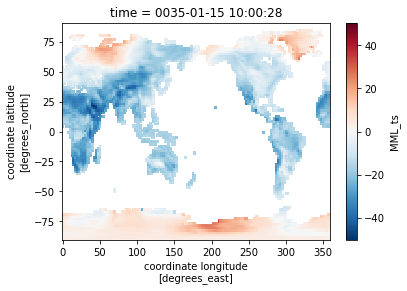

In [33]:
deltaTs_deltaHc.plot()

In [22]:
Albedo1.MML_ts-

IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

In [18]:
a1_cv2_hc0pt1_rs100=get_data('global_a1_cv2_hc0.1_rs100_cheyenne')

# Calculate coupled kernels
Data from Lague et al. paper

In [18]:
experiments=[Albedo1,Albedo3, REF, RS200, RS30]
for ds in experiments:
    ds['EF']=ds['MML_lhflx']/(ds['MML_lhflx']+ds['MML_shflx'])

In [19]:
delta_ts_Rs100to200=(RS200.MML_ts.mean(dim='time')-REF.MML_ts.mean(dim='time'))
delta_ts_Rs100to30=(RS30.MML_ts.mean(dim='time')-REF.MML_ts.mean(dim='time'))

In [20]:
delta_ts_Albedo2to1=(Albedo1.MML_ts.mean(dim='time')-REF.MML_ts.mean(dim='time'))
delta_ts_Albedo2to3=(Albedo3.MML_ts.mean(dim='time')-REF.MML_ts.mean(dim='time'))

In [21]:
delta_a=(0.1-0.2)
delta_Rs=(200-100)

In [22]:
v1=-delta_ts_Albedo2to1/0.1

In [23]:
v2=(delta_ts_Albedo2to3/0.1)

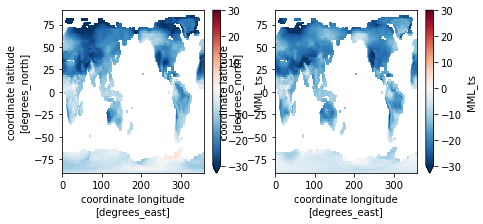

In [28]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
v1.plot(vmax=30)
plt.subplot(1,2,2)
v2.plot(vmax=30)

In [71]:
deltaTs_deltaAlbedo=delta_ts_Albedo2to1/delta_a
deltaTs_deltaRs=delta_ts_Rs100to200/delta_Rs

ds_deltaTs_deltaAlbedo=deltaTs_deltaAlbedo.to_dataset('coupled_deltaTs_deltaAlbedo')
ds_deltaTs_deltaRs=deltaTs_deltaRs.to_dataset('coupled_deltaTs_deltaRs')

In [72]:
# Save output
fpath_out='/glade/work/czarakas/coupled_PPE/data/Lague_kernels/'
ds_deltaTs_deltaAlbedo.to_netcdf(fpath_out+'coupled_deltaTs_deltaAlbedo.nc')
ds_deltaTs_deltaRs.to_netcdf(fpath_out+'coupled_ds_deltaTs_deltaRs.nc')

# Calculate offline kernels

In [8]:
ds_a1=xr.open_mfdataset('/glade/work/czarakas/Lague_kernels/global_a1_cv2_hc0.1_rs100_offline_b07/'+
                   'means/global_a1_cv2_hc0.1_rs100_offline_b07.clm2.h0.20-50_year_avg.nc')
ds_a2=xr.open_mfdataset('/glade/work/czarakas/Lague_kernels/global_a2_cv2_hc0.1_rs100_offline_b07/'+
                   'means/global_a2_cv2_hc0.1_rs100_offline_b07.clm2.h0.20-50_year_avg.nc')
ds_rs200=xr.open_mfdataset('/glade/work/czarakas/Lague_kernels/global_a2_cv2_hc0.1_rs200_offline_b07/'+
                   'means/global_a2_cv2_hc0.1_rs200_offline_b07.clm2.h0.20-50_year_avg.nc')

In [9]:
ds_rs200['EF']=ds_rs200.MML_lhflx.mean(dim='time')/(ds_rs200.MML_lhflx+ds_rs200.MML_shflx).mean(dim='time')
ds_a2['EF']=ds_a2.MML_lhflx.mean(dim='time')/(ds_a2.MML_lhflx+ds_a2.MML_shflx).mean(dim='time')
ds_a1['EF']=ds_a1.MML_lhflx.mean(dim='time')/(ds_a1.MML_lhflx+ds_a1.MML_shflx).mean(dim='time')

In [10]:
delta_ts_rs=(ds_rs200.MML_ts-ds_a2.MML_ts).mean(dim='time')
delta_ts_a=(ds_a1.MML_ts-ds_a2.MML_ts).mean(dim='time')
delta_rs=(ds_rs200.MML_evap_rs-ds_a2.MML_evap_rs).mean(dim='time')
delta_a=(ds_a1.MML_alb-ds_a2.MML_alb).mean(dim='time')

In [51]:
deltaTs_deltaAlbedo=delta_ts_a/delta_a
deltaTs_deltaRs=delta_ts_rs/delta_rs

ds_deltaTs_deltaAlbedo=deltaTs_deltaAlbedo.to_dataset('deltaTs_deltaAlbedo')
ds_deltaTs_deltaRs=deltaTs_deltaRs.to_dataset('deltaTs_deltaRs')

In [ ]:
delta_rs=(ds_rs200.MML_evap_rs-ds_a2.MML_evap_rs).mean(dim='time')

In [15]:
# Save output
fpath_out='/glade/work/czarakas/coupled_PPE/data/Lague_kernels/'
ds_deltaTs_deltaAlbedo.to_netcdf(fpath_out+'deltaTs_deltaAlbedo.nc')
ds_deltaTs_deltaRs.to_netcdf(fpath_out+'ds_deltaTs_deltaRs.nc')